# Recurrent Neural Network - Predict Stock Market with Finance Data and News Data
The source of inspiration was this blog post: 
https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8

This is the basis for training the neural network. 

### Import necesary libraries

In [40]:
import numpy as np
import time as tm
import datetime as dt

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

import pandas as pd

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt


### Settings

In [2]:
# Set the parametes need for the RNN

# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOG. Here we will get the stick ticker the others too.
STOCK = 'TSLA'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

### Load Data

In [3]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index


# We are then left with the following columns: 'close', 'date'

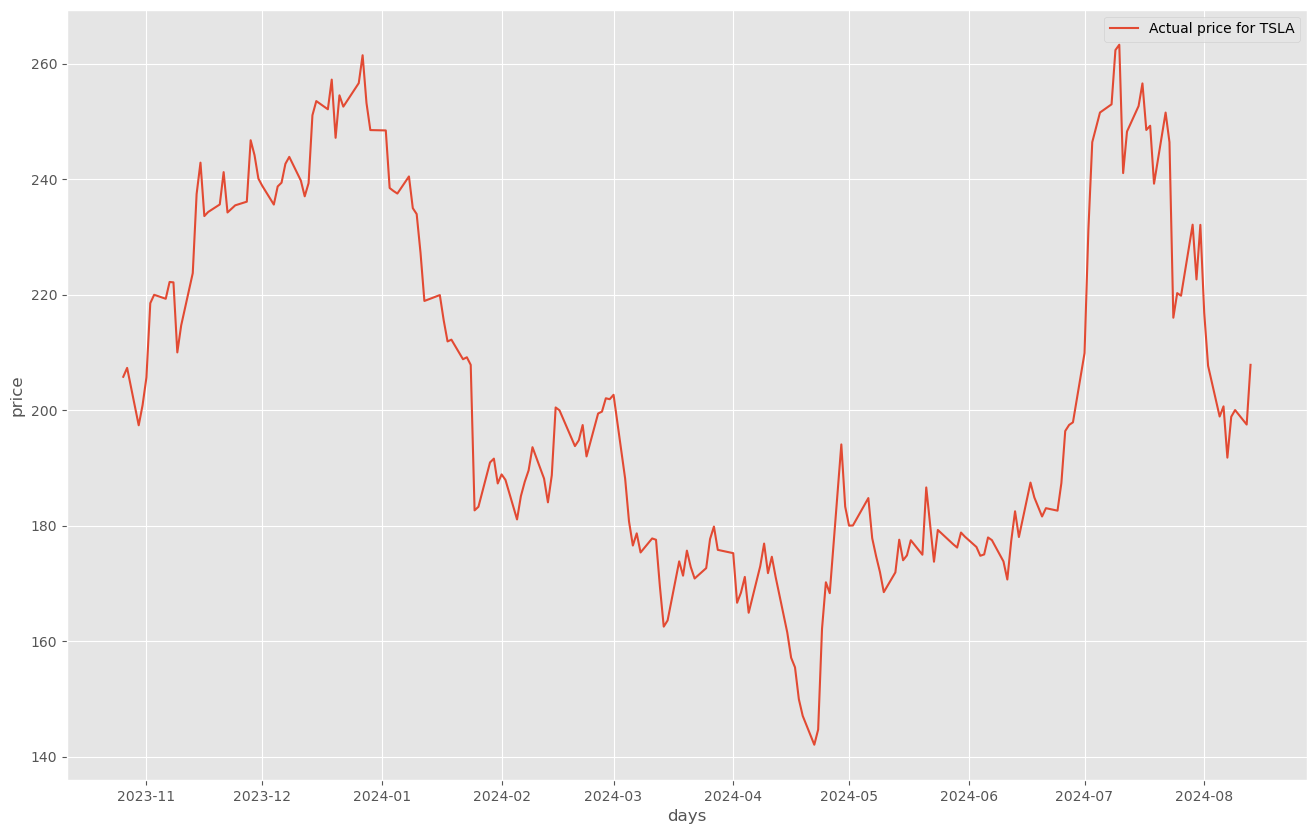

In [4]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

### Data Preparation

In [5]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

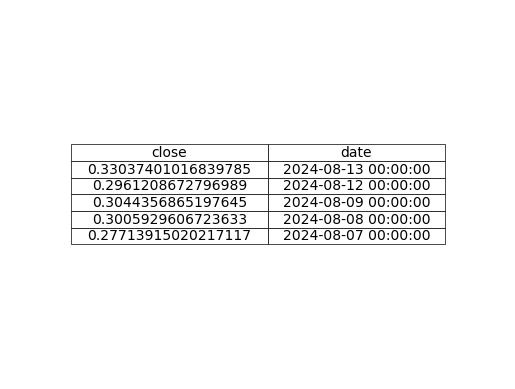

In [6]:
# Sort the dataframe in descending order based on the date column
sorted_df = init_df.sort_values(by='date', ascending=False)

# Select the top 5 records
top_5_records = sorted_df.head(5)

# Create a new figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('off')

# Create a table and add it to the figure
table = plt.table(cellText=top_5_records.values, colLabels=top_5_records.columns, cellLoc = 'center', loc='center')

# Auto scale the width of the columns
table.auto_set_column_width(col=list(range(len(top_5_records.columns))))

plt.show()

In [7]:
import duckdb
import os

class PredictionInputRepository:
    def __init__(self, csv_file_path=None):
        self.connection = duckdb.connect(database=':memory:', read_only=False)
        if os.path.isfile(f'{csv_file_path}/prediction_input.csv'):
            try:
                self.connection.execute(f"IMPORT DATABASE '{csv_file_path}';")
            except Exception as e:
                self._create_table()
                self.connection.execute(f"EXPORT DATABASE '{csv_file_path}';")
        else:
            self._create_table()

    def _create_table(self):
        self.connection.execute("CREATE TABLE prediction_input (id VARCHAR UNIQUE, articleId INTEGER UNIQUE, timestamp VARCHAR, close DOUBLE, relevance DOUBLE, sentimentPositive DOUBLE, sentimentNegative DOUBLE, sentimentNeutral DOUBLE)")
        self.connection.execute("CREATE SEQUENCE id_sequence START 1 INCREMENT BY 1;")

    def insert(self, prediction_input):
        self.connection.execute("PREPARE insert_prediction_input AS "
                                "INSERT INTO prediction_input VALUES (nextval('id_sequence'), ?, ?, ?, ?, ?, ?, ?) ON CONFLICT DO NOTHING;")
        self.connection.execute(f"EXECUTE insert_prediction_input('{prediction_input['articleId']}', '{prediction_input['timestamp']}', {prediction_input['close']}, {prediction_input['relevance']}, {prediction_input['sentimentPositive']}, {prediction_input['sentimentNegative']}, {prediction_input['sentimentNeutral']});")

    def select_all(self):
        return self.connection.execute("SELECT * FROM prediction_input").fetchdf()

    def select_by_date(self, date_from, date_to):
        return self.connection.execute(f"SELECT * FROM prediction_input WHERE strptime(timestamp, '%Y-%m-%dT%H:%M:%S%z') BETWEEN strptime('{date_from}','%Y-%m-%d') AND strptime('{date_to}','%Y-%m-%d')").fetchdf()
    
    def select_by_date_order(self, date_format = '%Y-%m-%dT%H:%M:%S%z'):
        return self.connection.execute(f"SELECT * FROM prediction_input ORDER BY strptime(timestamp, '{date_format}') DESC").fetchdf()

    def export(self, csv_file):
        self.connection.execute(f"EXPORT DATABASE '{csv_file}';")


# Prepare Prediction Input

/var/folders/9v/7v6_s_cx279bzt2ph9lwl8b80000gn/T/ipykernel_29412/1591749573.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  input_df["close"].ffill(inplace=True)
/var/folders/9v/7v6_s_cx279bzt2ph9lwl8b80000gn/T/ipykernel_29412/1591749573.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

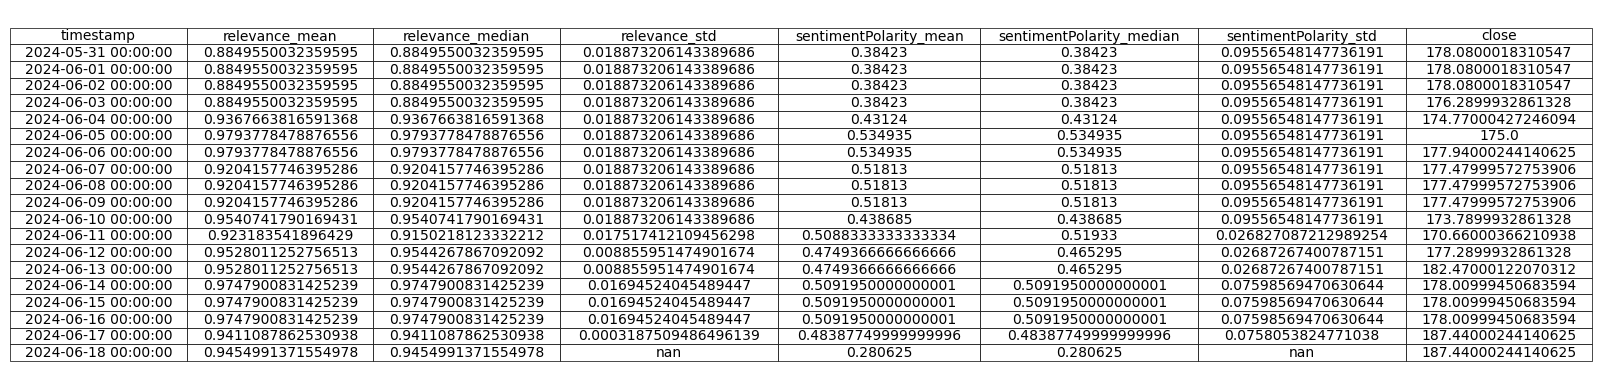

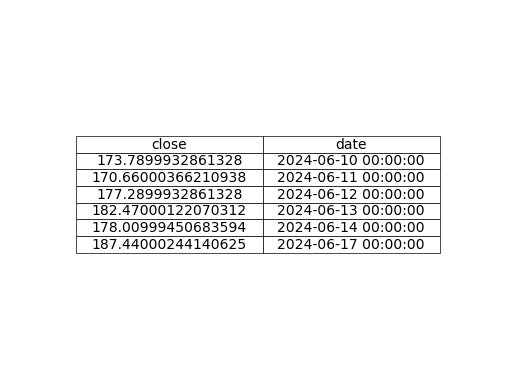

In [188]:
def prepare_prediction_input(source):
    prediction_input_repo = PredictionInputRepository(f"prediction_input/{source}")

    if source == "bbc":
        return prediction_input_repo.select_by_date_order("%Y-%m-%dT%H:%M:%S.%fZ")
    else:
        return prediction_input_repo.select_by_date_order().head(30)

# input as df
def show_prediction_input_table(prediction_input):
    most_ten_input_data = prediction_input.head(20)
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    table = plt.table(cellText=most_ten_input_data.values, colLabels=most_ten_input_data.columns, cellLoc = 'center', loc='center')
    table.auto_set_column_width(col=list(range(len(most_ten_input_data.columns))))
    plt.show()

def calculate_sentiment_polarity(rows):
    rows["sentimentPolarity"] = round(rows['sentimentPositive'] - rows['sentimentNegative'],5)
    rows["sentimentPolarity"] = np.interp(rows["sentimentPolarity"], (-1, 1), (0, 1)) if rows["relevance"] > 0 else 0
    rows = rows.drop(['sentimentPositive', 'sentimentNegative', 'sentimentNeutral'])
    return rows

def calculate_sentiment_statistics_per_day(input):
    input["timestamp"] = input["timestamp"].apply(lambda x: x.split("T")[0])
    input_temp = input.drop(input[input.relevance <= 0].index)
    input_temp = input_temp.groupby(["timestamp"], as_index=False).agg({"relevance": ["mean", "median", "std"], "sentimentPolarity": ["mean", "median", "std"]})
    
    input_temp.columns = [("_".join(x) if x[1] != "" else x[0]) for x in input_temp.columns.ravel()]

    return input_temp

def forward_fill_missing_dates_values(input_df):
    input_df["timestamp"] = pd.to_datetime(input_df["timestamp"])
    input_df = input_df.set_index("timestamp")
    input_df = input_df.resample("D").ffill().reset_index()
    return input_df

def forward_fill_missing_close_price_values(input_df):
    input_df["close"].ffill(inplace=True)
    input_df["relevance_std"].bfill(inplace=True)
    input_df["sentimentPolarity_std"].bfill(inplace=True)

    return input_df

def add_close_price_per_date(input_df):    
    min_date = str(input_df["timestamp"].min()).split(" ")[0]
    max_date = str(input_df["timestamp"].max()).split(" ")[0]
    
    stock_df = yf.get_data(
        STOCK,
        start_date=min_date,
        end_date=max_date,
        interval='1d')
    stock_df = stock_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
    stock_df['date'] = stock_df.index
    
    input_df = pd.merge(input_df, stock_df, left_on="timestamp", right_on="date", how="left").drop("date", axis=1)
    
    return input_df

def get_processed_dataframe_prediction_input(source):
    input_df = prepare_prediction_input(source).drop("close", axis=1)
    input_df = input_df.apply(calculate_sentiment_polarity, axis=1)
    input_df = calculate_sentiment_statistics_per_day(input_df)
    input_df = forward_fill_missing_dates_values(input_df)
    input_df = add_close_price_per_date(input_df)
    input_df = forward_fill_missing_close_price_values(input_df)
    return input_df

ft_input_df = get_processed_dataframe_prediction_input("ft")

stock_df = yf.get_data(
    STOCK,
    start_date="2024-06-10",
    end_date="2024-06-18",
    interval='1d')

# remove columns which our neural network will not use
stock_df = stock_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
stock_df['date'] = stock_df.index

show_prediction_input_table(ft_input_df)
show_prediction_input_table(stock_df)

In [11]:
def PrepareDataStock(days):
    df = init_df.copy()
    df['future'] = df['close'].shift(-days)
    last_sequence = np.array(df[['close']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return df, last_sequence, X, Y

### Model

In [12]:
def GetTrainedModel(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 8
    EPOCHS = 80

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    model.summary()

    return model

In [13]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
    df, last_sequence, x_train, y_train = PrepareDataStock(step)
    x_train = x_train[:, :, :len(['close'])].astype(np.float32)

    model = GetTrainedModel(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 2s 6ms/step - loss: 0.0157
Epoch 2/80
95/95 [==============================] - 1s 7ms/step - loss: 0.0038
Epoch 3/80
95/95 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 4/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0034
Epoch 5/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 6/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0031
Epoch 7/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0027
Epoch 8/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0026
Epoch 9/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0026
Epoch 10/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0023
Epoch 11/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 12/80
95/95 [==============================] - 1s 5ms/step - loss: 0.0022
Epoch 13/80
95/95 [==============================

In [14]:
if bool(predictions) == True and len(predictions) > 0:
    predictions_list = [str(d)+'$' for d in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{STOCK} prediction for upcoming 3 days: ({predictions_str})'
    print(message)

GOOGL prediction for upcoming 3 days: (175.72$, 175.71$, 176.7$)


In [17]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

24/24 [==============================] - 0s 3ms/step


ValueError: cannot set a row with mismatched columns